In [1]:
from Interval import *
import cv2
import json
import concurrent.futures
from itertools import repeat

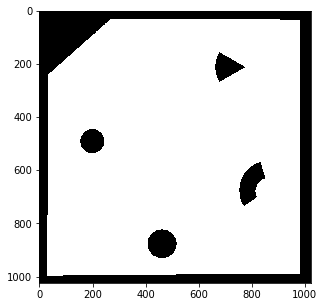

In [2]:
with open('obstacles.json') as f:   
    data = json.load(f)
obstacles = []
for obstacle in data['obstacles']:
    params,center = obstacle['params'],obstacle['center']
    obstacles.append(Interval(*params,center))
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r)
plt.show()
    

In [14]:
aa = [1.5,2.6,7.8,7.01,8.8]
np.random.choice(aa)

7.8

In [84]:
class Robot(Interval):
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    path = None
    Nr = 5
    Ntheta = 5
    Is = []
    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        super(Robot,self).__init__(*self.params)
        
    @property
    def params(self):
        theta1 = self.yaw
        theta2 = self.yaw + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta1)+np.cos(theta2))/(1e-6 + np.sin(theta1-theta2)),
                       self.y_bot+self.radius*(np.sin(theta1)+np.sin(theta2))/(1e-6 + np.sin(theta1-theta2)))

        n = self.radius/np.sin(1e-6+(theta2-theta1)/2)
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        return [nu1,nu2,theta1,theta2,origin]
        
    
    def collision_detection(self):
        Js = []
        #### maybe multiprocessing here
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             Js = [executor.submit(super(Robot,self).interval_analysis,obstacle,5,5)for obstacle in self.obstacles]
            
#         for f in concurrent.futures.as_completed(Js):
#             print(f)
        for obstacle in self.obstacles:
            J = self.interval_analysis(obstacle,5,5)
            if not(J.r2 == 1e-6 and J.theta1 == 1e-6 and J.theta2 == 1e-6):
                Js.append(J)
                print("collision detect ",J)    
        return Js
    
    @staticmethod
    def complement(I,J):
        if J.r2 == 1e-6 and J.theta1 == 1e-6 and J.theta2 == 1e-6:
            return [I]
        I1 = Interval(I.r1,I.r2,I.theta1,J.theta1,I.origin)
        I2 = Interval(I.r1,J.r1,J.theta1,J.theta2,I.origin)
        I3 = Interval(I.r1,I.r2,J.theta2,I.theta2,I.origin)
        return [I1,I2,I3]
    
    def generate_vw(self,I):
        min_angle = np.pi/24
        num_samples = np.floor((I.theta2-I.theta1)/min_angle).astype('int')
        vws = []
        v = (I.r2-I.r1-2*self.radius)/self.Δt
        for i in range(num_samples):
            w = I.theta1+(i+1)*min_angle*self.Δt ### sus I.theta1+
            vws.append([v,w])
            
        
            
        return vws
            
    def collision_avoidance(self,Js):
        """
        gives good v,w given bad v,w from the tracker
        """
#         w = w*np.random.uniform(-1,1)
        I = self
        vws = []
        Is = []
        for J in Js:
            comps = self.complement(I,J)
            if len(comps) != 3:
                continue
            else:
                for comp in comps:
                    comp_vws = self.generate_vw(comp)
                    vws += comp_vws
                    #print(vws)
            
            
        if len(vws) == 0:
            vws = self.generate_vw(I)
        #print(vws)    
        #idr = np.random.choice(range(len(vws)))
        for [v,w] in vws:
            Iz = Interval(0,v,w,w,(self.x_bot,self.y_bot))
            Is.append(Iz)
            
            
            
        return Is  
            
        
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         pose = [self.x_bot,self.y_bot,self.yaw]
#         Js = self.collision_detection()
#         v,w = self.collision_avoidance(Js)
#         self.x_bot += v*np.cos(self.yaw)*self.Δt
#         self.y_bot += v*np.sin(self.yaw)*self.Δt
#         self.yaw += w*self.Δt
# #         self.vj = v
# #         self.wj = w
#         super(Robot,self).__init__(*self.params)
        
        
#             #cook something that creates new v,w which do not crash into the obstacles 
#         #Robot(*pose,self.vi,self.vj,self.wi,self.wj)
#         return self
    def next_bot(self):
        Js = self.collision_detection()
        v,w = self.collision_avoidance(Js)
        x_bot = self.x_bot + v*np.cos(self.yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(self.yaw)*self.Δt
        yaw = self.yaw + w*self.Δt
        
        vi = self.vi
        vj = self.vj
        wi = self.wi
        wj = self.wj
        del self
        
        return Robot(x_bot,y_bot,yaw,vi,vj,wi,wj)
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
        return super(Robot,self).draw(ax,self.color)
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
    @classmethod
    def set_path(cls,path):
        cls.path = path    

In [44]:
robot = Robot(600,500,50,0,1.57,0,0)
robot.set_environment(obstacles)
#robot.generate_vw(robot)
next(robot)

collision_detect
1e-06
1e-06
0.0
[]
1e-06
1e-06
0.0
[]
1.57
1e-06
11.993908871967966
[[110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747]]
1e-06
1e-06
0.0
[[110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747]]
1e-06
1e-06
0.0
[[110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.178098245096172

1e-06
1e-06
0.0
[[110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747], [110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747], [110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747], [110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494

1e-06
1e-06
0.0
[[110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747], [110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747], [110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494], [110.0, 0.3927000816987241], [110.0, 0.5235997755982988], [110.0, 0.6544994694978735], [110.0, 0.7853991633974483], [110.0, 0.916298857297023], [110.0, 1.0471985511965975], [110.0, 1.1780982450961723], [110.0, 1.308997938995747], [110.0, 1e-06], [110.0, 0.1309006938995747], [110.0, 0.2618003877991494

In [3]:
aa = [1,2,3] 
aa += []
aa

[1, 2, 3]

In [42]:
aa = Interval(0,0,0,0)
bb = Interval(0,0,0,0)
aa == bb

False

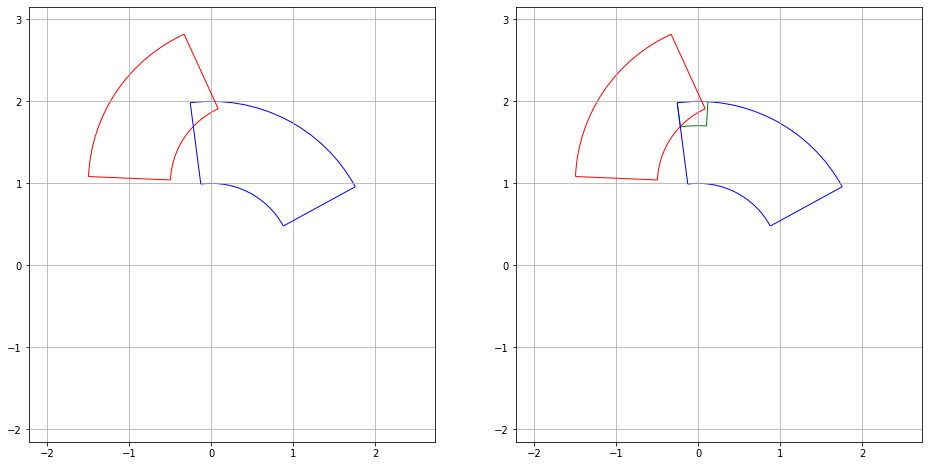

In [48]:
I2 = Interval(1,2,2,3.1,origin=(0.5,1))
I1 = Interval(1,2,0.5,1.7,origin=(0,0))

J = I1.interval_analysis(I2,5,5)

fig= plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,2,1)
I2.draw(ax,'red')
I1.draw(ax,'blue')
plt.axis('equal')
plt.grid()
ax1 = fig.add_subplot(1,2,2)
J.draw(ax1,'green')
I2.draw(ax1,'red')
I1.draw(ax1,'blue')
plt.axis('equal')
plt.grid()
plt.show()

In [45]:
def complement(I,J):
    I1 = Interval(I.r1,I.r2,I.theta1,J.theta1)
    I2 = Interval(I.r1,J.r1,J.theta1,J.theta2)
    I3 = Interval(I.r1,I.r2,J.theta2,I.theta2)
    return [I1,I2,I3]

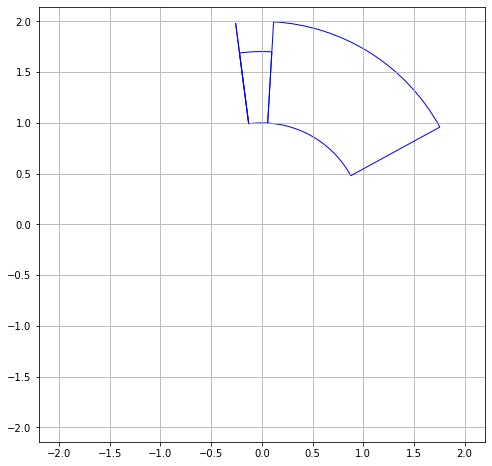

In [49]:
fig,ax = plt.subplots(figsize = (8,8))
# I1.draw(ax,'red')
# J.draw(ax,'green')
for I in complement(I1,J):
    I.draw(ax,'blue')
plt.axis('equal')
plt.grid()
plt.show()


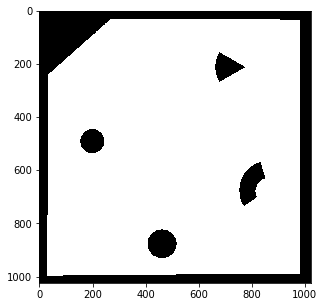

5


In [53]:
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r)
plt.show()


In [37]:
### no inheritance
class Robot:
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    path = None
    Nr = 5
    Ntheta = 5
    Is = []
    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        
    @property
    def interval(self):
        theta1 = self.yaw - (self.wi - self.wj)*self.Δt
        theta2 = self.yaw + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta1)+np.cos(theta2))/(1e-6 + np.sin(theta1-theta2)),
                       self.y_bot+self.radius*(np.sin(theta1)+np.sin(theta2))/(1e-6 + np.sin(theta1-theta2)))

        n = self.radius/np.sin(1e-6+(theta2-theta1)/2)
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        return Interval(nu1,nu2,theta1,theta2,origin)
        
    
    def collision_detection(self):
        Js = []
        #### maybe multiprocessing here
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             Js = [executor.submit(super(Robot,self).interval_analysis,obstacle,5,5)for obstacle in self.obstacles]
            
#         for f in concurrent.futures.as_completed(Js):
#             print(f)
        for obstacle in self.obstacles:
            J = self.interval.interval_analysis(obstacle,5,5)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
                print("collision detect ")    
        return Js

    
    def generate_vw(self):
        min_angle = np.pi/24
        num_samples = np.floor(((self.interval.theta2-self.interval.theta1)/min_angle)/2).astype('int')
        vws = []
        v = (self.interval.r2-self.interval.r1-2*self.radius)/self.Δt
        
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+   
            vws.append([v,-1*w])
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+
            vws.append([v,w])    
        return vws
            
    def collision_avoidance(self,Js,ax):
        """
        gives good v,w given bad v,w from the tracker
        """
#         w = w*np.random.uniform(-1,1)
        I = self.interval
        vws = self.generate_vw()

        for J in Js:
            comps = complement(I,J)
            for comp in comps:
                comp.draw(ax,'magenta')
                if comp.r2 == I.r2:
                    continue
                else:    
                    for i,[v,w] in enumerate(vws):
                        if I.theta1+w*self.Δt<= comp.theta2+2*np.pi/24 and I.theta1+w*self.Δt>=comp.theta1-2*np.pi/24:
                            #np.pi/24 is min angle
                            vnew = ((comp.r2-comp.r1-2*self.radius)/self.Δt)
                            vws[i][0] = vnew*(vnew>=0)
                            
                        
                    
                        
            
        idr = np.random.choice(range(len(vws)))
        print(vws)
            
            
#         vwes = np.array(vws)[::-1]
#         print(vws)
#         vwn = vwes[np.argmax(vwes[:,:1])]
#         print("vwn = ",vwn)

            
        return vws
            
        
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         pose = [self.x_bot,self.y_bot,self.yaw]
#         Js = self.collision_detection()
#         v,w = self.collision_avoidance(Js)
#         self.x_bot += v*np.cos(self.yaw)*self.Δt
#         self.y_bot += v*np.sin(self.yaw)*self.Δt
#         self.yaw += w*self.Δt
# #         self.vj = v
# #         self.wj = w
#         super(Robot,self).__init__(*self.params)
        
        
#             #cook something that creates new v,w which do not crash into the obstacles 
#         #Robot(*pose,self.vi,self.vj,self.wi,self.wj)
#         return self
    def next_bot(self,ax):
        Js = self.collision_detection()
        v,w = self.collision_avoidance(Js,ax)
#         for J in Js:
#             J.draw(ax,'magenta')
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        
        
#         vi = self.vi
#         vj = self.vj
#         wi = self.wi
#         wj = self.wj
        return self
    def next_bots(self,ax):
        bots = []
        Js = self.collision_detection()
        for [v,w] in self.collision_avoidance(Js,ax):
            yaw = self.yaw + w*self.Δt
            x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
            y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
            bots.append(Robot(x_bot,y_bot,yaw,self.vi,self.vj,self.wi,self.wj))
            
#         v,w = self.collision_avoidance(Js,ax)
#         for J in Js:
#             J.draw(ax,'magenta')
        
#         self.yaw = yaw
#         self.x_bot = x_bot
#         self.y_bot = y_bot
        
        
#         vi = self.vi
#         vj = self.vj
#         wi = self.wi
#         wj = self.wj
        return bots
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
#         for I in self.Is:
#             I.draw(ax,'green')
        self.interval.draw(ax,self.color)
        
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
    @classmethod
    def set_path(cls,path):
        cls.path = path    
        
        
    
def complement(I,J):
    if J.r2 == 1e-6 and J.theta1 == 1e-6 and J.theta2 == 1e-6:
        return [I]
    I1 = Interval(I.r1,I.r2,I.theta1,J.theta1,I.origin)
    I2 = Interval(I.r1,J.r1,J.theta1,J.theta2,I.origin)
    I3 = Interval(I.r1,I.r2,J.theta2,I.theta2,I.origin)
    return [I1,I2,I3]        

run : 0
collision detect 
[[80.0, -0.0], [80.0, -0.1308996938995747], [80.0, -0.2617993877991494], [80.0, -0.39269908169872414], [80.0, -0.5235987755982988], [80.0, -0.6544984694978735], [80.0, -0.7853981633974483], [80.0, 0.0], [80.0, 0.1308996938995747], [80.0, 0.2617993877991494], [80.0, 0.39269908169872414], [14.375, 0.5235987755982988], [14.375, 0.6544984694978735], [14.375, 0.7853981633974483]]
run : 1
collision detect 
[[-0.0, -0.0], [-0.0, -0.1308996938995747], [80.0, -0.2617993877991494], [80.0, -0.39269908169872414], [80.0, -0.5235987755982988], [80.0, -0.6544984694978735], [80.0, -0.7853981633974483], [-0.0, 0.0], [-0.0, 0.1308996938995747], [-0.0, 0.2617993877991494], [-0.0, 0.39269908169872414], [-0.0, 0.5235987755982988], [-0.0, 0.6544984694978735], [-0.0, 0.7853981633974483]]


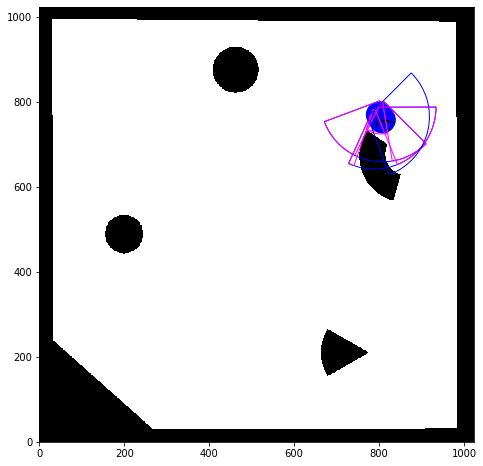

In [32]:
#robot = Robot(680,600,0,80,0,1.57,0)
# robot = Robot(680,600,0,80,0,1,0)
#robot = Robot(400,400,0,80,0,1,0)
robot = Robot(800,770,4.5,80,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
robot.plot(ax)
robot.plot_interval(ax)
for i in range(2):
    print("run :",i)
    pose = robot.next_bot(ax)
    pose.plot(ax)
    pose.plot_interval(ax)
#     for I in pose.Is:
#         I.draw(ax,'green')
    robot = pose
# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

[[80.0, -0.0], [80.0, -0.1308996938995747], [80.0, -0.2617993877991494], [80.0, -0.39269908169872414], [80.0, -0.5235987755982988], [80.0, -0.6544984694978735], [80.0, -0.7853981633974483], [80.0, 0.0], [80.0, 0.1308996938995747], [80.0, 0.2617993877991494], [80.0, 0.39269908169872414], [80.0, 0.5235987755982988], [80.0, 0.6544984694978735], [80.0, 0.7853981633974483]]


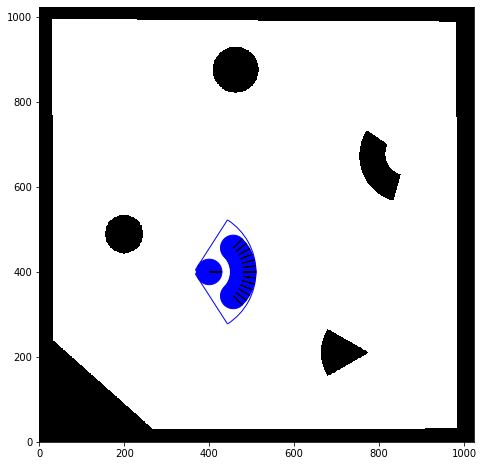

In [39]:
#robot = Robot(800,770,4.5,80,0,1,0)
robot = Robot(400,400,0,80,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
robot.plot(ax)
robot.plot_interval(ax)
robots = robot.next_bots(ax)
for pose in robots:

    #pose = robot.next_bot(ax)
    pose.plot(ax)
    #pose.plot_interval(ax)

KeyboardInterrupt: 

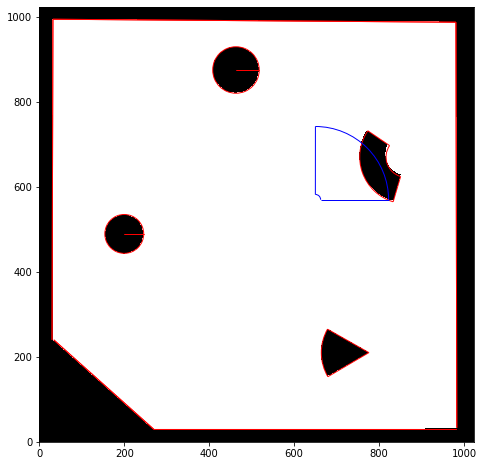

In [85]:
robot = Robot(680,600,0,100,0,1.57,0)
robot.set_environment(obstacles)

fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
temp_bot = robot
for obstacle in obstacles:
        obstacle.draw(ax,'red')
for _ in range(3):
    
    traj.append((temp_bot.x_bot,temp_bot.y_bot))  
    for I in temp_bot.Is:
        I.draw(ax,'green')
    #temp_bot.plot(ax)
    temp_bot.plot_interval(ax)
    temp_bot = temp_bot.next_bot()
    
path = np.array(traj).T    
ax.plot(path[0],path[1],'y-')

In [73]:
print(I)

Interval(1e-06,100.0,0.6544984694978735,0.6544984694978735,(780.0, 600.0))


collision detect  Interval(126.19326713039621,152.4432671303962,0.04906346875,0.83406296875,(649.9760706551165, 569.9999699999605))
[Interval(12.443267130396208,152.4432671303962,1e-06,0.04906346875,(649.9760706551165, 569.9999699999605)), Interval(12.443267130396208,126.19326713039621,0.04906346875,0.83406296875,(649.9760706551165, 569.9999699999605)), Interval(12.443267130396208,152.4432671303962,0.83406296875,1.57,(649.9760706551165, 569.9999699999605))]


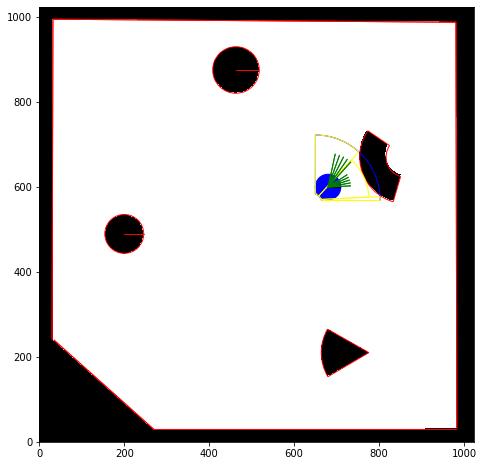

In [36]:
robot = Robot(680,600,0,80,0,1.57,0)
robot.set_environment(obstacles)
Js = robot.collision_detection()
comps = []
for J in Js:
    comps += robot.complement(robot,J)
print(comps)
    
Is = robot.collision_avoidance(Js)
    
fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
    obstacle.draw(ax,'red')
    
robot.plot(ax)
robot.plot_interval(ax)
for comp in comps:
    comp.draw(ax,'yellow')
for I in Is:
    I.draw(ax,'green')
del robot



collision detect  Interval(126.19326713039621,152.4432671303962,0.04906346875,0.83406296875,(649.9760706551165, 569.9999699999605))
[Interval(12.443267130396208,152.4432671303962,1e-06,0.04906346875,(649.9760706551165, 569.9999699999605)), Interval(12.443267130396208,126.19326713039621,0.04906346875,0.83406296875,(649.9760706551165, 569.9999699999605)), Interval(12.443267130396208,152.4432671303962,0.83406296875,1.57,(649.9760706551165, 569.9999699999605))]


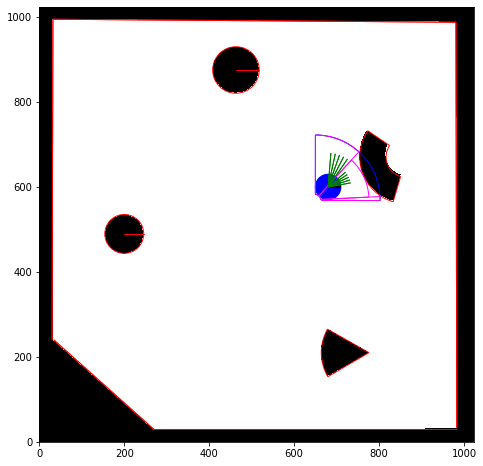

In [86]:
robot = Robot(680,600,0,80,0,1.57,0)
robot.set_environment(obstacles)
Js = robot.collision_detection()
comps = []
for J in Js:
    comps += robot.complement(robot,J)
print(comps)
    
Is = robot.collision_avoidance(Js)
    
fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
    obstacle.draw(ax,'red')
    
robot.plot(ax)
robot.plot_interval(ax)
for comp in comps:
    comp.draw(ax,'magenta')
for I in Is:
    I.draw(ax,'green')
del robot
plt.savefig("Robot_interval_plot.png")


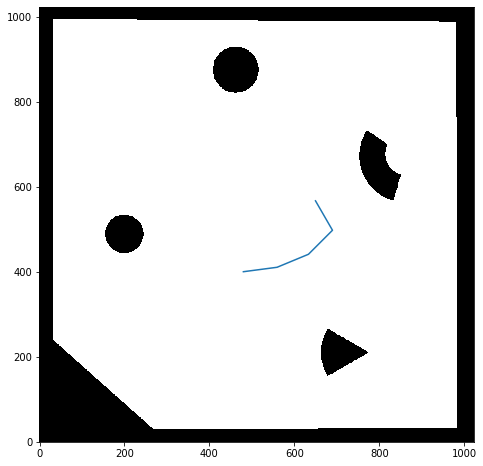

In [26]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')

p = np.array(traj).T    
ax.plot(p[0],p[1])
        

In [26]:
super(Robot,robot)

<super: __main__.Robot, <__main__.Robot at 0xb4f0870>>

In [33]:
s = np.random.uniform(-1,1)
print(s)

0.1392158175087026


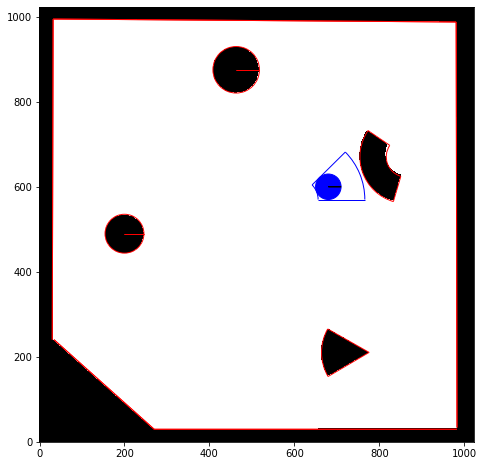

In [29]:

    
robot = Robot(680,600,0,50,0,0.78,0)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
    obstacle.draw(ax,'red')
robot.plot(ax)
robot.plot_interval(ax)
robot.set_environment(obstacles)
# Js = robot.collision_detection()
# for J in Js:
#     J.draw(ax,'green')


In [33]:
class Robot(Interval):
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    path = None
    Nr = 5
    Ntheta = 5
    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        self.theta1 = yaw
        self.theta2 = yaw + (wi - wj)*self.Δt
        self.origin = (x_bot+self.radius*(np.cos(self.theta1)+np.cos(self.theta2))/(1e-6 + np.sin(self.theta1-self.theta2)),
                       y_bot+self.radius*(np.sin(self.theta1)+np.sin(self.theta2))/(1e-6 + np.sin(self.theta1-self.theta2)))
        self.r1 = 0
        self.r2 = (vi-vj)*self.Δt
        n = self.radius/np.sin(1e-6+(self.theta2-self.theta1)/2)
        self.nu1 = n - self.radius
        self.nu2 = n + self.radius + self.r2
        super(Robot,self).__init__(self.nu1,self.nu2,self.theta1,self.theta2,self.origin)
    
    def collision_detection(self):
        Js = []
        #### maybe multiprocessing here
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             Js = [executor.submit(super(Robot,self).interval_analysis,obstacle,5,5)for obstacle in self.obstacles]
            
#         for f in concurrent.futures.as_completed(Js):
#             print(f)
        for obstacle in self.obstacles:
            Js.append(super(Robot,self).interval_analysis(obstacle,5,5))
        return Js
    
    def collision_avoidance(self,v,w,Js):
        """
        gives good v,w given bad v,w from the tracker
        """
        
        r,theta = v*self.Δt,w*self.Δt #bad r,theta
        p = Point(tuple(np.array(self.origin) + np.array([r*np.cos(theta),r*np.sin(theta)])))
        for J in Js:
            if p in J:
                break
        else:
            return v,w
        return self.collision_avoidance(v,J.theta1/self.Δt)    
            
        
    
    def __iter__(self):
        return self
    
    def __next__(self):
        pose = [self.x_bot,self.y_bot,self.yaw]
        x_bot_new = self.x_bot + (self.vi-self.vj)*np.cos(self.yaw)*self.Δt
        y_bot_new = self.y_bot + (self.vi-self.vj)*np.sin(self.yaw)*self.Δt
        yaw_new = self.yaw + (self.wi-self.wj)*self.Δt
        self.x_bot = x_bot_new
        self.y_bot = y_bot_new
        self.yaw = yaw_new
        
        return Robot(*pose,self.vi,self.vj,self.wi,self.wj)
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
        return super(Robot,self).draw(ax,self.color)
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
    @classmethod
    def set_path(cls,path):
        cls.path = path    

In [ ]:
class PurePursuitTracker:
  
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        if self.ref_idx >= self.length:
            ref_x,ref_y = self.x[-1],self.y[-1]
        else:  
            ref_x,ref_y = self.x[self.ref_idx],self.y[self.ref_idx]
        
        if self.ref_idx > self.length and np.sqrt((ref_x-self.x[-1])**2+ (ref_y-self.y[-1])**2) < goal_threshold: 
            return True           
        
        if np.sqrt((ref_x-xc)**2+ (ref_y-yc)**2) < lookahead:
            self.ref_idx += 1 
        
        anchor = np.asarray([ref_x - xc, ref_y - yc])

        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        
        L = np.sqrt(anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        
        X = anchor[0] 
        
        self.w = -2*self.v*X/L/L

        return False


In [ ]:
x,y,t = 
tracker = PurePursuitTracker(x,y,vmax) 
pose = 0, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting

traj = []
while True:
    print("v = ",tracker.v," w = ",tracker.w)
    pose = simulate_unicycle(pose,tracker.v,tracker.w)

    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx]) 